# Start

In [31]:
# # Code pour vider un dossier
# import os
# import shutil

# def clear_directory(path):
#     """
#     Supprime récursivement tout le contenu d'un répertoire donné,
#     puis recrée le répertoire vide.
#     """
#     if os.path.exists(path):
#         print(f"Suppression du contenu du dossier : {path}")
#         shutil.rmtree(path)
#         print(f"Dossier {path} et son contenu supprimés.")
#     else:
#         print(f"Le dossier {path} n'existe pas, pas de suppression nécessaire.")

#     os.makedirs(path, exist_ok=True)
#     print(f"Dossier {path} recréé et vide.")

# # --- Exemple d'utilisation (décommenter et remplacer 'YOUR_PATH_HERE') ---
# # ATTENTION: Assurez-vous que le chemin est correct, cette opération est irréversible.
# path_to_clear = "/content/drive/MyDrive/P8/Experiences/checkpoints"
# clear_directory(path_to_clear)


Suppression du contenu du dossier : /content/drive/MyDrive/P8/Experiences/checkpoints
Dossier /content/drive/MyDrive/P8/Experiences/checkpoints et son contenu supprimés.
Dossier /content/drive/MyDrive/P8/Experiences/checkpoints recréé et vide.


## Imports

In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks, losses, metrics, optimizers
from tensorflow.keras import applications
import shutil
import numpy as np

from pathlib import Path

import pandas as pd
!pip install mlflow -q
!pip install Pillow -q
import mlflow.tensorflow
import mlflow
import warnings

# Supprimer tous les warnings
warnings.filterwarnings("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 8.4 MB/s eta 0:00:00
TensorFlow version: 2.19.0


In [ ]:
from tensorflow.keras import mixed_precision

# Activation de la politique "mixed_float16"
# Cela permet d'utiliser des float16 pour les calculs (rapide) et float32 pour les variables (stable)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Mixed precision policy:', policy.compute_dtype)

Mixed precision policy: float16


## CONFIG PATHS

In [32]:
import os
from pathlib import Path
import mlflow

# --- CENTRALISATION DES CHEMINS (DRIVE) ---
PROJECT_ROOT = Path("/content/drive/MyDrive/P8")

# 1. Dossier Racine "Experiences"
EXP_ROOT = PROJECT_ROOT / "Experiences"

# 2. Sous-dossiers
# SEPARATION IMPORTANTE : On isole les logs MLflow dans 'mlruns'
# pour éviter qu'il ne scanne 'checkpoints' ou 'Models' comme des expériences.
MLFLOW_TRACKING_DIR = EXP_ROOT / "mlruns"
CHECKPOINTS_DIR     = EXP_ROOT / "checkpoints"
MODELS_DIR          = EXP_ROOT / "Models"
ARTIFACTS_DIR       = EXP_ROOT / "artefacts"

# Création automatique de l'arborescence
for path in [EXP_ROOT, MLFLOW_TRACKING_DIR, CHECKPOINTS_DIR, MODELS_DIR, ARTIFACTS_DIR]:
    if not path.exists():
        print(f"📁 Création dossier : {path}")
        path.mkdir(parents=True, exist_ok=True)

# Configuration MLflow immédiate
mlflow.set_tracking_uri("file://" + str(MLFLOW_TRACKING_DIR))

print("\n✅ CONFIGURATION TERMINÉE (Structure corrigée)")
print(f"📡 MLflow Tracking URI : {mlflow.get_tracking_uri()}")
print(f"💾 Checkpoints : {CHECKPOINTS_DIR}")
print(f"📦 Modèles Finaux : {MODELS_DIR}")


✅ CONFIGURATION TERMINÉE (Structure corrigée)
📡 MLflow Tracking URI : file:///content/drive/MyDrive/P8/Experiences/mlruns
💾 Checkpoints : /content/drive/MyDrive/P8/Experiences/checkpoints
📦 Modèles Finaux : /content/drive/MyDrive/P8/Experiences/Models


In [ ]:
import os
from pathlib import Path
import mlflow

# Get the currently configured MLflow tracking URI
# Ensure MLFLOW_TRACKING_DIR is defined, if not, re-evaluate previous cells or set it here.
# Assuming MLFLOW_TRACKING_DIR from cell 'vzdfsFXfMy9c' is available:
mlflow_tracking_path = Path(mlflow.get_tracking_uri().replace("file://", ""))
mlflow_trash_dir = mlflow_tracking_path / ".trash"

# Create the .trash directory if it does not exist
if not mlflow_trash_dir.exists():
    try:
        mlflow_trash_dir.mkdir(parents=True, exist_ok=True)
        print(f"📁 Dossier MLflow .trash créé : {mlflow_trash_dir}")
    except Exception as e:
        print(f"⚠️ Erreur lors de la création du dossier MLflow .trash : {e}")
else:
    print(f"📁 Le dossier MLflow .trash existe déjà : {mlflow_trash_dir}")


📁 Dossier MLflow .trash créé : /content/drive/MyDrive/P8/Experiences/mlruns/.trash


## Mounting Drive

In [ ]:
import os
import shutil
from google.colab import drive

mount_point = '/content/drive'

# Check if the mount point exists and has contents
if os.path.exists(mount_point) and os.listdir(mount_point):
    print(f"Clearing existing contents in {mount_point} before mounting...")
    try:
        # Try to unmount first, in case it's a partially mounted or stale mount.
        # This command is often necessary before trying to clear or remount.
        _ = !fusermount -uz {mount_point}
        print(f"Successfully unmounted {mount_point}.")
    except Exception as e:
        print(f"Could not unmount {mount_point}: {e}. Proceeding with clearing directory.")

    # Remove all contents from the directory. If it was a broken mount, this cleans up.
    # If it's just a directory with files, this clears it for the mount.
    for item in os.listdir(mount_point):
        item_path = os.path.join(mount_point, item)
        try:
            if os.path.islink(item_path) or os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Error removing {item_path}: {e}. This might prevent successful mounting.")
            # We don't want to halt execution here, as drive.mount will raise if it's still an issue.

drive.mount(mount_point, force_remount=True)

Mounted at /content/drive


## Initializing Repository

In [ ]:
import os
import glob

# 1. Définition des Chemins
# DRIVE_SOURCE = "/content/drive/MyDrive/P8"   # Là où sont stockés vos zips (Source lente)
DRIVE_SOURCE = "/content/drive/MyDrive/P8/Data" # Essayez celui-ci si le premier ne trouve rien

LOCAL_DEST = "/content/P8/Data"              # Là où on veut travailler (Destination rapide)

print(f"🔄 Initialisation de la copie : Drive -> {LOCAL_DEST}")

if not os.path.exists(LOCAL_DEST):
    os.makedirs(LOCAL_DEST)

# 2. Recherche automatique des fichiers ZIP sur le Drive
# On cherche tout ce qui commence par 'P8_Cityscapes' et finit par '.zip'
found_zips = glob.glob(os.path.join(DRIVE_SOURCE, "**", "P8_Cityscapes*.zip"), recursive=True)

if not found_zips:
    print("❌ ERREUR CRITIQUE : Aucun fichier zip trouvé dans le Drive !")
    print(f"J'ai cherché dans : {DRIVE_SOURCE}")
    print("Vérifiez le chemin exact dans la colonne de gauche 'drive > MyDrive > ...'")
else:
    print(f"✅ Fichiers ZIP trouvés sur le Drive : {len(found_zips)}")
    for zip_file in found_zips:
        print(f"   -> Copie et Décompression de : {os.path.basename(zip_file)} ...")
        # Unzip silencieux (-q) mais avec écrasement (-o) vers le dossier local
        !unzip -q -o "{zip_file}" -d "{LOCAL_DEST}"

    print("\n🎉 SUCCESS : Toutes les données sont prêtes sur le Disque Rapide !")

    # 3. Configuration des variables GLOBALES
    IMG_DIR = os.path.join(LOCAL_DEST, "leftImg8bit")
    MASK_DIR = os.path.join(LOCAL_DEST, "gtFine")

    print(f"📁 IMG_DIR = {IMG_DIR}")
    if os.path.exists(IMG_DIR):
         print(f"   Contenu : {os.listdir(IMG_DIR)}")
    else:
         print("⚠️ Attention : Le dossier leftImg8bit n'est pas apparu. Vérifiez la structure du zip.")

🔄 Initialisation de la copie : Drive -> /content/P8/Data
✅ Fichiers ZIP trouvés sur le Drive : 2
   -> Copie et Décompression de : P8_Cityscapes_gtFine_trainvaltest.zip ...
   -> Copie et Décompression de : P8_Cityscapes_leftImg8bit_trainvaltest.zip ...

🎉 SUCCESS : Toutes les données sont prêtes sur le Disque Rapide !
📁 IMG_DIR = /content/P8/Data/leftImg8bit
   Contenu : ['train', 'test', 'val']


# Data Preparing

## Loading Data

In [ ]:
from pathlib import Path
import os

# --- 1. CONFIGURATION DES CHEMINS ---

# DRIVE (Stockage Permanent Résultats)
PROJECT_ROOT = Path("/content/drive/MyDrive/P8")

# LOCAL (Stockage Temporaire Rapide pour Données)
# C'est ici que le script 'unzip' a déposé les images
DATA_DIR_LOCAL = Path("/content/P8/Data")

IMG_DIR = DATA_DIR_LOCAL / "leftImg8bit"
MASK_DIR = DATA_DIR_LOCAL / "gtFine"

# Vérification
print(f"📂 INPUT (Lecture Rapide) : {IMG_DIR} -> Exists? {IMG_DIR.exists()}")
print(f"💾 OUTPUT (Sauvegarde Drive) : {PROJECT_ROOT} -> Exists? {PROJECT_ROOT.exists()}")

if not IMG_DIR.exists():
    print("⚠️ ATTENTION : Les données locales ne sont pas trouvées. Avez-vous lancé le script 'Unzip' ?")

📂 INPUT (Lecture Rapide) : /content/P8/Data/leftImg8bit -> Exists? True
💾 OUTPUT (Sauvegarde Drive) : /content/drive/MyDrive/P8 -> Exists? True


In [ ]:
print("Cities train images:", os.listdir(os.path.join(IMG_DIR, "train"))[:3])
print("Cities train masks:", os.listdir(os.path.join(MASK_DIR, "train"))[:3])

Cities train images: ['dusseldorf', 'strasbourg', 'krefeld']
Cities train masks: ['dusseldorf', 'strasbourg', 'krefeld']


## Fonction de listing image / masque

In [ ]:
from glob import glob
from PIL import Image

def get_file_pairs(split="train"):
    img_paths = []
    mask_paths = []

    for city in os.listdir(os.path.join(IMG_DIR, split)):
        city_img_dir = os.path.join(IMG_DIR, split, city)
        city_mask_dir = os.path.join(MASK_DIR, split, city)

        for img_file in glob(os.path.join(city_img_dir, "*_leftImg8bit.png")):
            mask_file = os.path.join(
                city_mask_dir,
                os.path.basename(img_file).replace(
                    "_leftImg8bit.png",
                    "_gtFine_labelIds.png"
                )
            )

            if os.path.exists(mask_file):
                try:
                    with Image.open(img_file) as img_pil:
                        img_pil.verify()
                    with Image.open(mask_file) as mask_pil:
                        mask_pil.verify()

                    img_paths.append(img_file)
                    mask_paths.append(mask_file)
                except Exception as e:
                    print(f"Skipping corrupted image/mask pair (INVALID PNG DATA): {img_file}, {mask_file} - Error: {e}")
            else:
                print(f"Skipping image due to missing mask file: {img_file}")

    return img_paths, mask_paths


## Test du chargement des chemins

In [ ]:
train_imgs, train_masks = get_file_pairs("train")
val_imgs, val_masks = get_file_pairs("val")

print(f"Train images: {len(train_imgs)}")
print(f"Val images: {len(val_imgs)}")

print(train_imgs[0])
print(train_masks[0])

Train images: 2975
Val images: 500
/content/P8/Data/leftImg8bit/train/dusseldorf/dusseldorf_000041_000019_leftImg8bit.png
/content/P8/Data/gtFine/train/dusseldorf/dusseldorf_000041_000019_gtFine_labelIds.png


## Chargement image + masque

In [ ]:
import cv2
import numpy as np

IMG_HEIGHT = 256
IMG_WIDTH = 512

CITYSCAPES_TO_8 = {
    7: 0, 8: 0,
    11: 1, 12: 1,
    13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2,
    24: 3, 25: 3,
    21: 4,
    23: 5,
    19: 6, 20: 6, 22: 6,
    9: 7, 10: 7, 0: 7
}

def load_image_mask(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT),
                      interpolation=cv2.INTER_NEAREST)

    new_mask = np.zeros_like(mask)
    for k, v in CITYSCAPES_TO_8.items():
        new_mask[mask == k] = v

    return img.astype(np.float32), new_mask.astype(np.uint8)


In [ ]:
import tensorflow as tf
import numpy as np
# Installation silencieuse d'albumentations si nécessaire
try:
    import albumentations as A
except ImportError:
    import os
    os.system('pip install -q albumentations')
    import albumentations as A

# --- Paramètres du Pipeline ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Mapping des Classes (Identique à avant) ---
MAPPING_LIST = [
    7, 7, 7, 7, 7, 7, 7, # 0-6: void
    0, 0, 0, 0,          # 7-10: flat
    3, 3, 3, 3, 3, 3,    # 11-16: construction
    4, 4, 4, 4,          # 17-20: object
    5, 5,                # 21-22: nature
    6,                   # 23: sky
    1, 1,                # 24-25: human
    2, 2, 2, 2, 2, 2, 2, 2, # 26-33: vehicle
    7                    # 34: license plate
]
MAPPING_TENSOR = tf.constant(MAPPING_LIST + [7] * (256 - len(MAPPING_LIST)), dtype=tf.int32)

# --- Configuration Albumentations (Equivalent à votre demande) ---
aug_transform = A.Compose([
    A.HorizontalFlip(p=0.5),

    # Transformations géométriques (Rotation, Shift, Scale)
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=15,
        border_mode=0, # Remplit les bords avec 0 (noir/void)
        p=0.7
    ),

    # Effets visuels (ne touchent que l'image, pas le masque)
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
        A.ElasticTransform(p=1.0, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
    ], p=0.5),

    A.RandomBrightnessContrast(p=0.5),
])

def parse_image_mask(img_path, mask_path):
    """ Chargement standard """
    # 1. Image
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Masque
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask, tf.int32)

    # 3. Mapping
    mask = tf.gather(MAPPING_TENSOR, mask)

    return img, mask

def albumentations_augment(img, mask):
    """ Wrapper pour utiliser Albumentations dans TensorFlow """

    def aug_fn(image, mask):
        # Conversion TensorFlow -> Numpy
        data = {"image": image, "mask": mask}
        augmented = aug_transform(**data)
        return augmented["image"], augmented["mask"]

    # Appel via tf.numpy_function
    aug_img, aug_mask = tf.numpy_function(
        func=aug_fn,
        inp=[img, mask],
        Tout=[tf.float32, tf.int32]
    )

    # Restauration des formes (perdues par numpy_function)
    aug_img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    aug_mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])

    return aug_img, aug_mask

def create_dataset(img_paths, mask_paths, training=False, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

    if training:
        dataset = dataset.shuffle(1000)

    # Parsing (Lecture fichiers)
    dataset = dataset.map(parse_image_mask, num_parallel_calls=AUTOTUNE)

    # Application Augmentation (Si training)
    if training and augment_data:
        dataset = dataset.map(albumentations_augment, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3181978279.py:47: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=1.0, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
/tmp/ipython-input-3181978279.py:48: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),


## Creating Datasets

In [ ]:
# Création des datasets
# Train avec augmentation
train_ds_aug = create_dataset(train_imgs, train_masks, training=True, augment_data=True)
# Train sans augmentation (pour comparaison)
train_ds_no_aug = create_dataset(train_imgs, train_masks, training=True, augment_data=False)
# Validation (jamais d'augmentation)
val_ds = create_dataset(val_imgs, val_masks, training=False)

full_train_dataset = train_ds_no_aug.concatenate(train_ds_aug)
full_train_dataset = full_train_dataset.shuffle(buffer_size=1000)

print(f"Datasets créés. Batch size: {BATCH_SIZE}")
# Vérification d'un batch
for img, mask in train_ds_aug.take(1):
    print(f"Image shape: {img.shape}, Type: {img.dtype}")
    print(f"Mask shape: {mask.shape}, Type: {mask.dtype}")

print(f"Dataset prêt.")
print(f"Images originales : {len(train_imgs)}")
print(f"Images totales par epoch (Originales + Augmentées) : {len(train_imgs) * 2}")

Datasets créés. Batch size: 32
Image shape: (32, 224, 224, 3), Type: <dtype: 'float32'>
Mask shape: (32, 224, 224, 1), Type: <dtype: 'int32'>
Dataset prêt.
Images originales : 2975
Images totales par epoch (Originales + Augmentées) : 5950


### Vérification de l'augmentation des données

Visualisation des échantillons SANS augmentation:


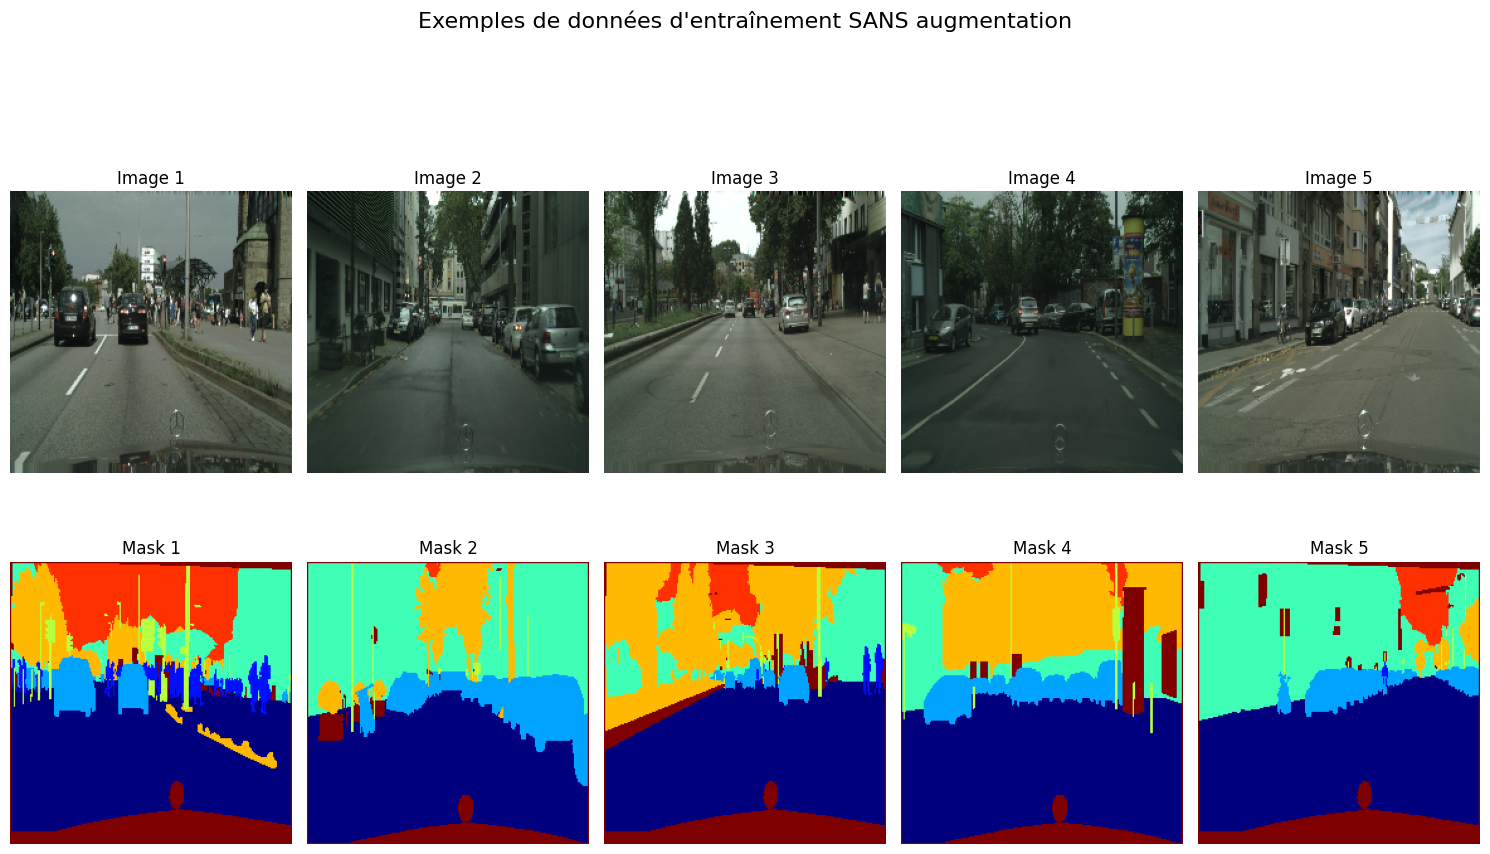


Visualisation des échantillons AVEC augmentation:


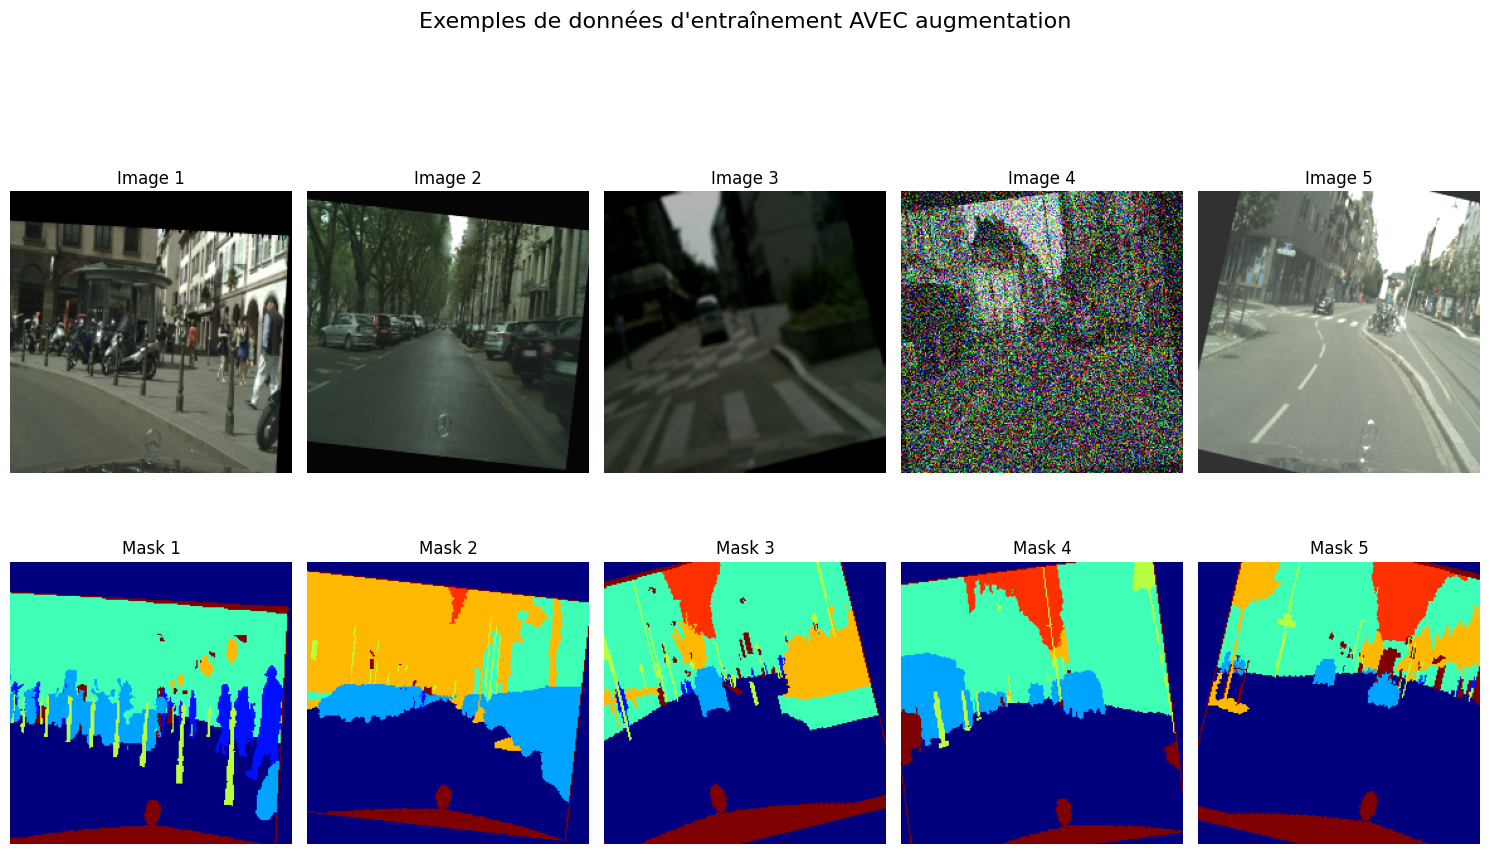

In [ ]:
import matplotlib.pyplot as plt

def visualize_augmented_samples(dataset, title, num_samples=5):
    plt.figure(figsize=(15, 2 * num_samples))
    plt.suptitle(title, fontsize=16)

    for i, (images, masks) in enumerate(dataset.take(1)):
        if i >= num_samples:
            break

        for j in range(num_samples):
            if j >= images.shape[0]: # Ensure we don't go out of bounds if batch size is smaller than num_samples
                break

            # Image
            plt.subplot(2, num_samples, j + 1)
            plt.imshow(images[j])
            plt.title(f"Image {j+1}")
            plt.axis("off")

            # Mask
            plt.subplot(2, num_samples, num_samples + j + 1)
            plt.imshow(masks[j], cmap='jet', vmin=0, vmax=7) # Using cmap='jet' for better visibility of classes
            plt.title(f"Mask {j+1}")
            plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("Visualisation des échantillons SANS augmentation:")
visualize_augmented_samples(train_ds_no_aug, "Exemples de données d'entraînement SANS augmentation", num_samples=5)

print("\nVisualisation des échantillons AVEC augmentation:")
visualize_augmented_samples(train_ds_aug, "Exemples de données d'entraînement AVEC augmentation", num_samples=5)

In [ ]:
# Vérification du nombre d'images dans chaque dataset

def count_examples(dataset):
    n = 0
    for batch_imgs, _ in dataset:
        n += batch_imgs.shape[0]
    return n

n_train_no_aug = count_examples(train_ds_no_aug)
n_train_aug    = count_examples(train_ds_aug)
n_val          = count_examples(val_ds)

print(f"Train SANS augmentation : {n_train_no_aug} images")
print(f"Train AVEC augmentation : {n_train_aug} images")
print(f"Validation              : {n_val} images")

# Rappel : nombre d'images source (pairs) dans train/val
print(f"Paires train d'origine : {len(train_imgs)}")
print(f"Paires val d'origine   : {len(val_imgs)}")

Train SANS augmentation : 2975 images
Train AVEC augmentation : 2975 images
Validation              : 500 images
Paires train d'origine : 2975
Paires val d'origine   : 500


## Visualisation d’un exemple

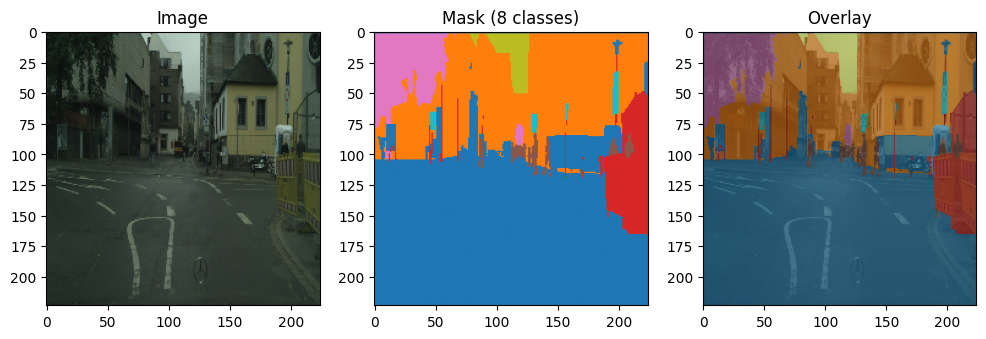

In [ ]:
import matplotlib.pyplot as plt

img, mask = load_image_mask(train_imgs[0], train_masks[0])

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="tab10")
plt.title("Mask (8 classes)")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(mask, cmap="tab10", alpha=0.5)
plt.title("Overlay")

plt.show()

# Loss function for optimizing models

In [ ]:
# --- Définition de la Dice Loss Custom ---
def dice_loss(y_true, y_pred):
    """
    Dice Loss pour segmentation multiclasse
    y_true: labels sparse (batch, h, w, 1) ou (batch, h, w)
    y_pred: probabilités (batch, h, w, num_classes)
    """
    y_true = tf.cast(y_true, tf.int32)
    # One-hot encoding du masque réel pour matcher la forme de y_pred
    y_true_one_hot = tf.one_hot(tf.squeeze(y_true), depth=8) # 8 classes

    numerator = 2 * tf.reduce_sum(y_true_one_hot * y_pred, axis=(0,1,2))
    denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=(0,1,2))

    # Dice par classe (ajout d'un epsilon pour éviter division par 0)
    dice_score = (numerator + 1e-7) / (denominator + 1e-7)

    # On renvoie 1 - dice_moyen
    return 1 - tf.reduce_mean(dice_score)

# --- Définition de la Loss Combinée (Combo Loss) ---
def combo_loss(y_true, y_pred):
    # Poids pour équilibrer (souvent 1:1 marche bien)
    ce = losses.sparse_categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return ce + dice

# --- Mise à jour de la configuration ---
# On utilise maintenant notre combo_loss au lieu de juste Crossentropy
# loss_fn = losses.SparseCategoricalCrossentropy()  <-- Ancienne
loss_fn = combo_loss  # <-- Nouvelle
optimizer = optimizers.Adam(learning_rate=1e-5)

# Training function

In [ ]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    """
    Version de MeanIoU capable de gérer les sorties de probabilités (Softmax).
    Elle prend l'argmax (la classe la plus probable) avant de calculer l'IoU.
    """
    def __init__(self, num_classes, name=None, dtype=None, **kwargs):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # On transforme les probabilités (Batch, H, W, 8) en labels (Batch, H, W)
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # On s'assure que tout est au bon format
        y_true = tf.cast(y_true, self.dtype)
        y_pred = tf.cast(y_pred, self.dtype)

        return super(UpdatedMeanIoU, self).update_state(y_true, y_pred, sample_weight)

def train_model(model, train_ds, val_ds, run_name, epochs=50):
    print(f"\n🚀 DÉMARRAGE RUN : {run_name}")

    # A. Préparation Checkpoint
    run_ckpt_dir = CHECKPOINTS_DIR / run_name
    if not run_ckpt_dir.exists():
        run_ckpt_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = str(run_ckpt_dir / "best_model.keras")

    # B. Callbacks
    # On surveille val_accuracy car c'est robuste et stable
    ckpt = callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
    es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=12, restore_best_weights=True, verbose=1)
    lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

    # C. Compilation (AVEC LA CORRECTION DU CRASH)
    # On utilise UpdatedMeanIoU au lieu de metrics.MeanIoU
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['accuracy', UpdatedMeanIoU(num_classes=8, name='mean_io_u')], # <--- La correction est ici
        run_eagerly=True # Gardez True pour éviter tout conflit de graphe avec la custom loss
    )

    # D. MLflow Run
    mlflow.set_experiment("Segmentation_P8")
    with mlflow.start_run(run_name=run_name) as run:
        mlflow.log_params({"model": model.name, "optimizer": "adam", "loss": str(loss_fn.__name__ if hasattr(loss_fn, '__name__') else 'custom')})
        mlflow.tensorflow.autolog(log_models=False)

        # Entraînement
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[ckpt, es, lr]
        )

        # E. Evaluation finale propre
        print("\n📊 Évaluation finale sur le dataset de validation...")
        # On charge le meilleur modèle pour l'évaluation
        best_model = tf.keras.models.load_model(ckpt_path, custom_objects={'combo_loss': combo_loss, 'dice_loss': dice_loss, 'UpdatedMeanIoU': UpdatedMeanIoU})

        # Calcul des métriques détaillées (IoU par classe)
        # (J'ai simplifié cette partie pour éviter les boucles manuelles lourdes,
        # on fait confiance aux métriques Keras calculées sur la validation)
        val_res = best_model.evaluate(val_ds, return_dict=True)

        print("-" * 35)
        print(f"🏆 Résultats Finaux (Best Model) :")
        print(f"   Accuracy : {val_res.get('accuracy', 0):.4f}")
        print(f"   Mean IoU : {val_res.get('mean_io_u', 0):.4f}")
        print(f"   Loss     : {val_res.get('loss', 0):.4f}")
        print("-" * 35)

        # Sauvegarde modèle final
        run_model_dir = MODELS_DIR / run_name
        if not run_model_dir.exists(): run_model_dir.mkdir(parents=True, exist_ok=True)
        best_model.save(str(run_model_dir / "final_model.keras"))
        print(f"📦 Modèle sauvegardé dans : {run_model_dir}")

        return history

# Model DeepLabV3+ - MobileNetV2

In [34]:
# --- Modèle 3 : DeepLabV3+ (Light Version avec MobileNetV2) ---

def build_deeplabv3_plus(input_shape, num_classes=8):
    inputs = layers.Input(shape=input_shape)

    # 1. Backbone MobileNetV2
    base_model = applications.MobileNetV2(
        input_tensor=inputs,
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # --- GEL DE L'ENCODEUR (TRANSFER LEARNING) ---
    # On gèle toutes les couches du backbone MobileNetV2 pour stabiliser le décodeur
    base_model.trainable = False

    # Extraction des features clés
    # High-level features (semantic) -> Sortie du dernier bloc (stride 16 ou 32)
    # Low-level features (details) -> Sortie début réseau (stride 4)
    x = base_model.get_layer('block_13_expand_relu').output  # Features riches (1/16)
    low_level_features = base_model.get_layer('block_3_expand_relu').output # Détails (1/4)

    # 2. Module ASPP (Atrous Spatial Pyramid Pooling)
    # Permet de voir le contexte à plusieurs échelles

    # Branche 1 : Conv 1x1
    b1 = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)

    # Branche 2 : Atrous Conv rate=6
    b2 = layers.Conv2D(256, 3, padding='same', dilation_rate=6, use_bias=False)(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)

    # Branche 3 : Atrous Conv rate=12
    b3 = layers.Conv2D(256, 3, padding='same', dilation_rate=12, use_bias=False)(x)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.Activation('relu')(b3)

    # Branche 4 : Image Pooling (Contexte global)
    b4 = layers.GlobalAveragePooling2D()(x)
    b4 = layers.Reshape((1, 1, x.shape[-1]))(b4) # (Batch, 1, 1, Channels)
    b4 = layers.Conv2D(256, 1, padding='same', use_bias=False)(b4)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.Activation('relu')(b4)
    # Upsample b4 pour matcher la taille des autres branches
    b4 = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(b4)

    # Concaténation ASPP
    x = layers.Concatenate()([b1, b2, b3, b4])
    x = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 3. Décodeur (Upsampling & Fusion)

    # On remonte x (1/16) vers la taille des low_level (1/4)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    # Préparation des low_level_features (réduction de dimension 1x1)
    low_level = layers.Conv2D(48, 1, padding='same', use_bias=False)(low_level_features)
    low_level = layers.BatchNormalization()(low_level)
    low_level = layers.Activation('relu')(low_level)

    # Fusion
    x = layers.Concatenate()([x, low_level])

    # Dernières convolutions pour raffiner
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Upsampling final vers la taille originale (1/4 -> 1/1)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    # Sortie Finale
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', dtype='float32')(x)

    return models.Model(inputs, outputs, name="DeepLabV3_MobileNetV2")

# Test build
model_deeplab = build_deeplabv3_plus(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)
model_deeplab.summary()

Model: "DeepLabV3_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 5,134,088 (19.58 MB)

 Trainable params: 4,514,152 (17.22 MB)

 Non-trainable params: 619,936 (2.36 MB)

### Sans Data Augmentation

In [36]:
# --- Expérience 3.1 : DeepLabV3+ SANS Augmentation ---

# 1. Instanciation
model_deeplab_no_aug = build_deeplabv3_plus(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)

# ⚠️ IMPORTANT : Reset Optimizer to avoid conflicts
optimizer = optimizers.Adam(learning_rate=1e-5)

# 2. Entraînement
history_deeplab_no_aug = train_model(
    model=model_deeplab_no_aug,
    train_ds=train_ds_no_aug,
    val_ds=val_ds,
    run_name="DeepLabV3_MobileNet_NoAug",
    epochs=15
)


🚀 DÉMARRAGE RUN : DeepLabV3_MobileNet_NoAug


2026/02/09 09:43:09 INFO mlflow.tracking.fluent: Experiment with name 'Segmentation_P8' does not exist. Creating a new experiment.


Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.4429 - loss: 2.4225 - mean_io_u: 0.1959
Epoch 1: val_accuracy improved from -inf to 0.67354, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 959ms/step - accuracy: 0.4448 - loss: 2.4167 - mean_io_u: 0.1969 - val_accuracy: 0.6735 - val_loss: 2.1477 - val_mean_io_u: 0.3205 - learning_rate: 1.0000e-05
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.7901 - loss: 1.2101 - mean_io_u: 0.4578
Epoch 2: val_accuracy improved from 0.67354 to 0.77571, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 89s 957ms/step - accuracy: 0.7901 - loss: 1.2097 - mean_io_u: 0.4579 - val_accuracy: 0.7757 - val_loss: 1.3791 - val_mean_io_u: 0.4534 - learning_rate: 1.0000e-05
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.8135 - loss: 1.0584 - mean_io_u: 0.5109
Epoch 3: val_accuracy improved from 0.77571 to 0.79976, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 89s 951ms/step - accuracy: 0.8135 - loss: 1.0582 - mean_io_u: 0.5110 - val_accuracy: 0.7998 - val_loss: 1.1346 - val_mean_io_u: 0.5012 - learning_rate: 1.0000e-05
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8235 - loss: 0.9824 - mean_io_u: 0.5390
Epoch 4: val_accuracy improved from 0.79976 to 0.81057, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 88s 945ms/step - accuracy: 0.8235 - loss: 0.9824 - mean_io_u: 0.5390 - val_accuracy: 0.8106 - val_loss: 1.0401 - val_mean_io_u: 0.5249 - learning_rate: 1.0000e-05
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.8317 - loss: 0.9295 - mean_io_u: 0.5547
Epoch 5: val_accuracy improved from 0.81057 to 0.81816, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 89s 957ms/step - accuracy: 0.8317 - loss: 0.9295 - mean_io_u: 0.5547 - val_accuracy: 0.8182 - val_loss: 0.9856 - val_mean_io_u: 0.5402 - learning_rate: 1.0000e-05
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.8338 - loss: 0.9025 - mean_io_u: 0.5636
Epoch 6: val_accuracy improved from 0.81816 to 0.82333, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 960ms/step - accuracy: 0.8338 - loss: 0.9024 - mean_io_u: 0.5636 - val_accuracy: 0.8233 - val_loss: 0.9519 - val_mean_io_u: 0.5499 - learning_rate: 1.0000e-05
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8385 - loss: 0.8742 - mean_io_u: 0.5733
Epoch 7: val_accuracy improved from 0.82333 to 0.82646, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 89s 956ms/step - accuracy: 0.8385 - loss: 0.8742 - mean_io_u: 0.5733 - val_accuracy: 0.8265 - val_loss: 0.9292 - val_mean_io_u: 0.5582 - learning_rate: 1.0000e-05
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.8421 - loss: 0.8552 - mean_io_u: 0.5791
Epoch 8: val_accuracy improved from 0.82646 to 0.82879, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 961ms/step - accuracy: 0.8421 - loss: 0.8552 - mean_io_u: 0.5791 - val_accuracy: 0.8288 - val_loss: 0.9128 - val_mean_io_u: 0.5640 - learning_rate: 1.0000e-05
Epoch 9/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.8466 - loss: 0.8264 - mean_io_u: 0.5896
Epoch 9: val_accuracy improved from 0.82879 to 0.83140, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 959ms/step - accuracy: 0.8466 - loss: 0.8264 - mean_io_u: 0.5895 - val_accuracy: 0.8314 - val_loss: 0.8975 - val_mean_io_u: 0.5692 - learning_rate: 1.0000e-05
Epoch 10/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.8498 - loss: 0.8103 - mean_io_u: 0.5957
Epoch 10: val_accuracy improved from 0.83140 to 0.83303, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 89s 954ms/step - accuracy: 0.8497 - loss: 0.8104 - mean_io_u: 0.5957 - val_accuracy: 0.8330 - val_loss: 0.8850 - val_mean_io_u: 0.5739 - learning_rate: 1.0000e-05
Epoch 11/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.8521 - loss: 0.7970 - mean_io_u: 0.5996
Epoch 11: val_accuracy improved from 0.83303 to 0.83552, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 89s 953ms/step - accuracy: 0.8521 - loss: 0.7970 - mean_io_u: 0.5996 - val_accuracy: 0.8355 - val_loss: 0.8724 - val_mean_io_u: 0.5788 - learning_rate: 1.0000e-05
Epoch 12/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.8546 - loss: 0.7826 - mean_io_u: 0.6051
Epoch 12: val_accuracy improved from 0.83552 to 0.83639, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 967ms/step - accuracy: 0.8546 - loss: 0.7826 - mean_io_u: 0.6051 - val_accuracy: 0.8364 - val_loss: 0.8646 - val_mean_io_u: 0.5823 - learning_rate: 1.0000e-05
Epoch 13/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.8557 - loss: 0.7736 - mean_io_u: 0.6095
Epoch 13: val_accuracy improved from 0.83639 to 0.83807, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 961ms/step - accuracy: 0.8557 - loss: 0.7735 - mean_io_u: 0.6095 - val_accuracy: 0.8381 - val_loss: 0.8552 - val_mean_io_u: 0.5855 - learning_rate: 1.0000e-05
Epoch 14/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.8582 - loss: 0.7586 - mean_io_u: 0.6141
Epoch 14: val_accuracy improved from 0.83807 to 0.83885, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 961ms/step - accuracy: 0.8582 - loss: 0.7586 - mean_io_u: 0.6141 - val_accuracy: 0.8388 - val_loss: 0.8507 - val_mean_io_u: 0.5868 - learning_rate: 1.0000e-05
Epoch 15/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8613 - loss: 0.7443 - mean_io_u: 0.6194
Epoch 15: val_accuracy improved from 0.83885 to 0.84019, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_NoAug/best_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 958ms/step - accuracy: 0.8613 - loss: 0.7444 - mean_io_u: 0.6194 - val_accuracy: 0.8402 - val_loss: 0.8434 - val_mean_io_u: 0.5905 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 15.

📊 Évaluation finale sur le dataset de validation...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 32 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - accuracy: 0.8402 - loss: 0.8385 - mean_io_u: 0.5912
-----------------------------------
🏆 Résultats Finaux (Best Model) :
   Accuracy : 0.8402
   Mean IoU : 0.5905
   Loss     : 0.8434
-----------------------------------
📦 Modèle sauvegardé dans : /content/drive/MyDrive/P8/Experiences/Models/DeepLabV3_MobileNet_NoAug


### Avec Data Augmentation

In [37]:
# --- Expérience 3.2 : DeepLabV3+ AVEC Augmentation ---

# 1. Instanciation (pour repartir de zéro)
model_deeplab_aug = build_deeplabv3_plus(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=8
)

# ⚠️ IMPORTANT : Reset Optimizer to avoid conflicts
optimizer = optimizers.Adam(learning_rate=1e-5)

# 2. Entraînement
history_deeplab_aug = train_model(
    model=model_deeplab_aug,
    train_ds=full_train_dataset,  # Dataset avec augmentation
    val_ds=val_ds,
    run_name="DeepLabV3_MobileNet_WithAug",
    epochs=15
)


🚀 DÉMARRAGE RUN : DeepLabV3_MobileNet_WithAug


Epoch 1/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.5333 - loss: 2.1254 - mean_io_u: 0.2254
Epoch 1: val_accuracy improved from -inf to 0.77703, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 202s 817ms/step - accuracy: 0.5340 - loss: 2.1231 - mean_io_u: 0.2258 - val_accuracy: 0.7770 - val_loss: 1.5071 - val_mean_io_u: 0.4479 - learning_rate: 1.0000e-05
Epoch 2/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.7757 - loss: 1.2453 - mean_io_u: 0.4436
Epoch 2: val_accuracy improved from 0.77703 to 0.80362, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 820ms/step - accuracy: 0.7757 - loss: 1.2451 - mean_io_u: 0.4437 - val_accuracy: 0.8036 - val_loss: 1.1098 - val_mean_io_u: 0.5114 - learning_rate: 1.0000e-05
Epoch 3/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.7993 - loss: 1.1002 - mean_io_u: 0.4920
Epoch 3: val_accuracy improved from 0.80362 to 0.81475, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 202s 816ms/step - accuracy: 0.7993 - loss: 1.1002 - mean_io_u: 0.4920 - val_accuracy: 0.8147 - val_loss: 1.0097 - val_mean_io_u: 0.5364 - learning_rate: 1.0000e-05
Epoch 4/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8062 - loss: 1.0424 - mean_io_u: 0.5123
Epoch 4: val_accuracy improved from 0.81475 to 0.82147, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 818ms/step - accuracy: 0.8062 - loss: 1.0424 - mean_io_u: 0.5123 - val_accuracy: 0.8215 - val_loss: 0.9572 - val_mean_io_u: 0.5509 - learning_rate: 1.0000e-05
Epoch 5/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8130 - loss: 1.0038 - mean_io_u: 0.5212
Epoch 5: val_accuracy improved from 0.82147 to 0.82660, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 204s 824ms/step - accuracy: 0.8130 - loss: 1.0038 - mean_io_u: 0.5212 - val_accuracy: 0.8266 - val_loss: 0.9284 - val_mean_io_u: 0.5596 - learning_rate: 1.0000e-05
Epoch 6/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8171 - loss: 0.9769 - mean_io_u: 0.5295
Epoch 6: val_accuracy improved from 0.82660 to 0.83050, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 822ms/step - accuracy: 0.8171 - loss: 0.9768 - mean_io_u: 0.5295 - val_accuracy: 0.8305 - val_loss: 0.9011 - val_mean_io_u: 0.5694 - learning_rate: 1.0000e-05
Epoch 7/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.8232 - loss: 0.9422 - mean_io_u: 0.5431
Epoch 7: val_accuracy improved from 0.83050 to 0.83286, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 819ms/step - accuracy: 0.8232 - loss: 0.9422 - mean_io_u: 0.5431 - val_accuracy: 0.8329 - val_loss: 0.8796 - val_mean_io_u: 0.5762 - learning_rate: 1.0000e-05
Epoch 8/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.8273 - loss: 0.9180 - mean_io_u: 0.5520
Epoch 8: val_accuracy improved from 0.83286 to 0.83621, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 819ms/step - accuracy: 0.8273 - loss: 0.9181 - mean_io_u: 0.5520 - val_accuracy: 0.8362 - val_loss: 0.8636 - val_mean_io_u: 0.5810 - learning_rate: 1.0000e-05
Epoch 9/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8295 - loss: 0.9067 - mean_io_u: 0.5546
Epoch 9: val_accuracy improved from 0.83621 to 0.83790, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 204s 824ms/step - accuracy: 0.8295 - loss: 0.9066 - mean_io_u: 0.5546 - val_accuracy: 0.8379 - val_loss: 0.8523 - val_mean_io_u: 0.5854 - learning_rate: 1.0000e-05
Epoch 10/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8342 - loss: 0.8844 - mean_io_u: 0.5642
Epoch 10: val_accuracy improved from 0.83790 to 0.83985, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 821ms/step - accuracy: 0.8342 - loss: 0.8844 - mean_io_u: 0.5642 - val_accuracy: 0.8399 - val_loss: 0.8441 - val_mean_io_u: 0.5876 - learning_rate: 1.0000e-05
Epoch 11/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8395 - loss: 0.8555 - mean_io_u: 0.5747
Epoch 11: val_accuracy improved from 0.83985 to 0.84109, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 820ms/step - accuracy: 0.8395 - loss: 0.8556 - mean_io_u: 0.5747 - val_accuracy: 0.8411 - val_loss: 0.8303 - val_mean_io_u: 0.5925 - learning_rate: 1.0000e-05
Epoch 12/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.8375 - loss: 0.8594 - mean_io_u: 0.5728
Epoch 12: val_accuracy improved from 0.84109 to 0.84205, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 204s 823ms/step - accuracy: 0.8375 - loss: 0.8594 - mean_io_u: 0.5728 - val_accuracy: 0.8420 - val_loss: 0.8227 - val_mean_io_u: 0.5953 - learning_rate: 1.0000e-05
Epoch 13/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.8410 - loss: 0.8411 - mean_io_u: 0.5783
Epoch 13: val_accuracy improved from 0.84205 to 0.84407, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 821ms/step - accuracy: 0.8409 - loss: 0.8412 - mean_io_u: 0.5783 - val_accuracy: 0.8441 - val_loss: 0.8144 - val_mean_io_u: 0.5985 - learning_rate: 1.0000e-05
Epoch 14/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8407 - loss: 0.8463 - mean_io_u: 0.5770
Epoch 14: val_accuracy improved from 0.84407 to 0.84517, saving model to /content/drive/MyDrive/P8/Experiences/checkpoints/DeepLabV3_MobileNet_WithAug/best_model.keras


186/186 ━━━━━━━━━━━━━━━━━━━━ 203s 820ms/step - accuracy: 0.8407 - loss: 0.8462 - mean_io_u: 0.5770 - val_accuracy: 0.8452 - val_loss: 0.8070 - val_mean_io_u: 0.6007 - learning_rate: 1.0000e-05
Epoch 15/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8477 - loss: 0.8072 - mean_io_u: 0.5931
Epoch 15: val_accuracy did not improve from 0.84517


186/186 ━━━━━━━━━━━━━━━━━━━━ 202s 815ms/step - accuracy: 0.8477 - loss: 0.8073 - mean_io_u: 0.5931 - val_accuracy: 0.8450 - val_loss: 0.8017 - val_mean_io_u: 0.6025 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 14.

📊 Évaluation finale sur le dataset de validation...
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.8457 - loss: 0.8040 - mean_io_u: 0.6021
-----------------------------------
🏆 Résultats Finaux (Best Model) :
   Accuracy : 0.8452
   Mean IoU : 0.6007
   Loss     : 0.8070
-----------------------------------
📦 Modèle sauvegardé dans : /content/drive/MyDrive/P8/Experiences/Models/DeepLabV3_MobileNet_WithAug


### MLFLOW checking

In [38]:
import mlflow
import pandas as pd

# Affichage complet
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

try:
    exp = mlflow.get_experiment_by_name("Segmentation_P8")
    if exp:
        # Récupérer TOUS les runs (pas de filtre)
        runs = mlflow.search_runs(experiment_ids=[exp.experiment_id])

        # Ajouter les métriques final_mean_iou et final_mean_dice à la liste des colonnes
        cols = [
            "tags.mlflow.runName", "status", "metrics.loss",
            "metrics.accuracy", "metrics.val_loss", "metrics.val_accuracy",
            "metrics.final_mean_iou", "metrics.final_mean_dice" # Ajouté ici
        ]
        # Filtrer colonnes existantes
        cols = [c for c in cols if c in runs.columns]

        if not runs.empty:
            print("--- 🏆 CLASSEMENT FINAL DES MODÈLES ---")
            # Tri par val_loss croissante (le plus petit est le meilleur)
            classement = runs[cols].sort_values("metrics.val_loss", ascending=True)
            display(classement)

            # Reco automatique
            best_model_name = classement.iloc[0]["tags.mlflow.runName"]
            print(f"\n👉 Le modèle recommandé pour le déploiement est : {best_model_name}")
        else:
            print("Aucun run trouvé.")
except Exception as e:
    print(f"Erreur MLflow: {e}")

--- 🏆 CLASSEMENT FINAL DES MODÈLES ---


tags.mlflow.runName    status  metrics.loss  metrics.accuracy  metrics.val_loss  metrics.val_accuracy
0  DeepLabV3_MobileNet_WithAug  FINISHED      0.827384          0.843627          0.801738              0.844983
1    DeepLabV3_MobileNet_NoAug  FINISHED      0.749049          0.859894          0.843358              0.840193


👉 Le modèle recommandé pour le déploiement est : DeepLabV3_MobileNet_WithAug


### Visualisations examples

Visualisation avec le dernier modèle entraîné...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


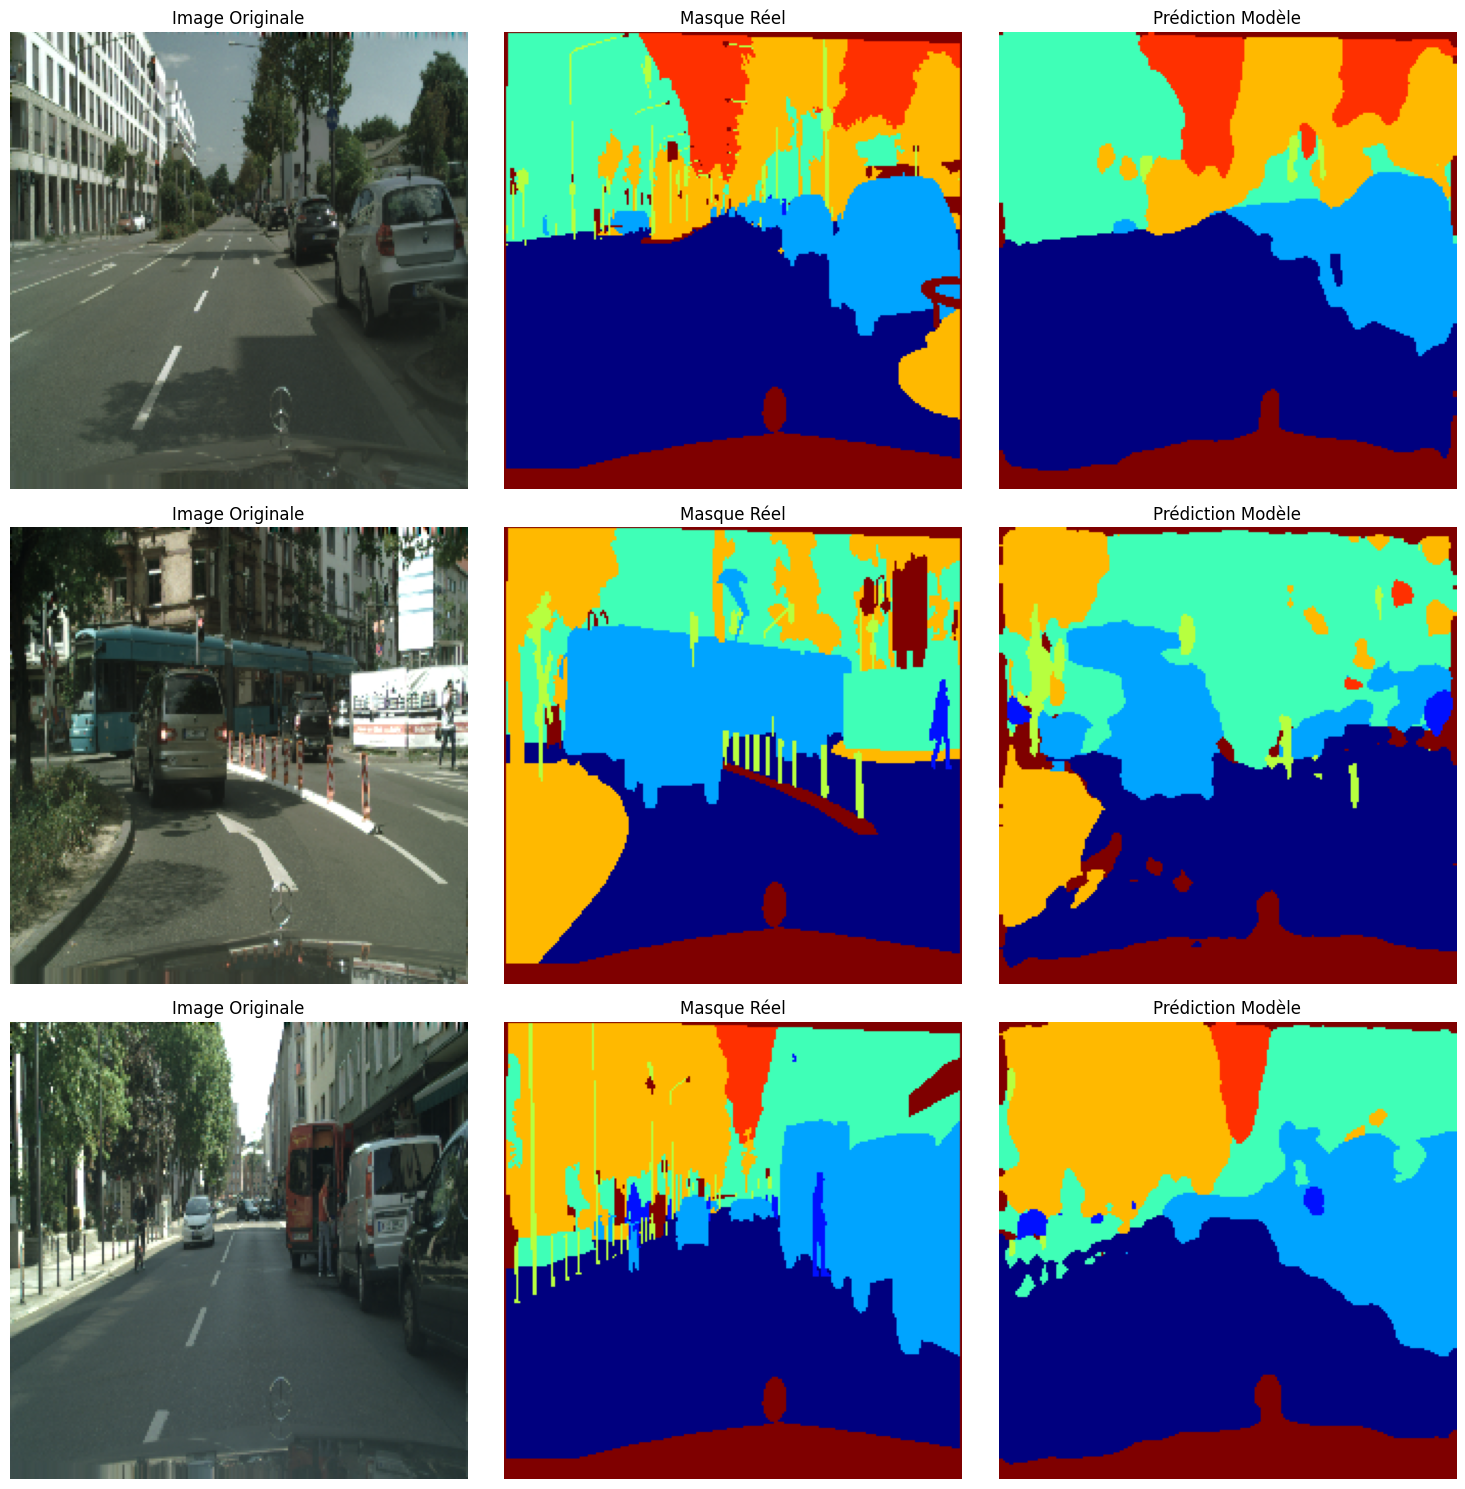

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num_samples=3):
    """ Affiche Image Réelle / Masque Réel / Masque Predit """

    # Récupérer un batch
    for images, masks in dataset.take(1):
        # Prédiction
        preds = model.predict(images)
        # Argmax pour avoir la classe dominante par pixel
        preds = np.argmax(preds, axis=-1)

        plt.figure(figsize=(15, 5 * num_samples))

        for i in range(num_samples):
            # 1. Image Originale
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(images[i])
            plt.title("Image Originale")
            plt.axis("off")

            # 2. Masque Réel (Ground Truth)
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(masks[i], cmap='jet', vmin=0, vmax=7)
            plt.title("Masque Réel")
            plt.axis("off")

            # 3. Prédiction
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(preds[i], cmap='jet', vmin=0, vmax=7)
            plt.title("Prédiction Modèle")
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break

# Lancer la visualisation sur le dataset de validation
# (Utilise le dernier modèle en mémoire, assurez-vous d'avoir entraîné un modèle avant)
try:
    print("Visualisation avec le dernier modèle entraîné...")
    visualize_predictions(model_deeplab_aug, val_ds) # Remplacez par le modèle que vous voulez tester
except NameError:
    print("Veuillez d'abord entraîner un modèle (ex: model_deeplab_aug) avant de visualiser.")

# Générations de schémas des modèles (pour documentation seulement)

schémas pour fiches techniques

In [41]:
from tensorflow.keras.utils import plot_model

# Création du dossier pour stocker les images dans le Drive
rapport_images_dir = PROJECT_ROOT / "Documentation/Rapport_Images"
os.makedirs(rapport_images_dir, exist_ok=True)

print("Génération du schéma DeepLabV3+...")
plot_model(
    model_deeplab_no_aug,
    to_file=f'{rapport_images_dir}/model_deeplab_structure.png',
    show_shapes=True,
    show_layer_names=False
)

print("✅ Images générées dans le dossier 'Rapport_Images'. Vous pouvez les télécharger pour votre rapport.")

Génération du schéma DeepLabV3+...
"dot" with args ['-Tpng', '/tmp/tmplwgxwq92/tmps952t710'] returned code: -6

stdout, stderr:
 b''
b"newtrap: Trapezoid-table overflow 3041\ndot: trapezoid.c:84: newtrap: Assertion `0' failed.\n"



AssertionError: "dot" with args ['-Tpng', '/tmp/tmplwgxwq92/tmps952t710'] returned code: -6

images colorées

In [42]:
!pip install visualkeras --quiet
import visualkeras

rapport_images_dir = PROJECT_ROOT / "Documentation/Rapport_Images"
os.makedirs(rapport_images_dir, exist_ok=True)

def save_flat_visual(model, filename):
    print(f"Génération visuelle 2D (Flat) pour {model.name}...")
    try:
        # draw_volume=False pour désactiver la 3D
        img = visualkeras.layered_view(
            model,
            legend=True,
            draw_volume=False,  # <--- C'est ici que ça se joue
            spacing=15,          # Espacement entre couches
            scale_xy=2           # Grossir un peu les carrés
        )
        save_path = f"{rapport_images_dir}/{filename}"
        img.save(save_path)
        print(f"✅ Sauvegardé : {save_path}")
        display(img)
    except Exception as e:
        print(f"Erreur : {e}")

# Génération pour vos modèles

save_flat_visual(model_deeplab_no_aug, "flat_deeplab.png")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.0 MB/s eta 0:00:00
Génération visuelle 2D (Flat) pour DeepLabV3_MobileNetV2...
Erreur : 'InputLayer' object has no attribute 'output_shape'


/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
